# Evaluating k-Means Clustering (Practice Walkthrough)

This practice notebook recreates and expands upon the course lab on evaluating k-means clustering. It adds richer commentary, clear step-by-step explanations, and lightweight exercises so you can solidify the key ideas before moving on.

## What you will learn

- Generate synthetic datasets tailored for clustering experiments.
- Train k-means models and visualize their behaviour.
- Interpret silhouette plots, inertia, and the Davies–Bouldin index.
- Explore how random initialization and the choice of *k* affect the final clusters.
- Recognise scenarios where k-means is not the right tool and consider alternatives.

> **Tip:** All of the data in this notebook is generated on the fly with `scikit-learn`, so you do not need to download any external files.

## 1. Setup and imports
We'll start by importing the scientific Python stack we need for the experiments.

- `numpy` for numerical work
- `matplotlib` for plotting
- `scikit-learn` for data generation and clustering
- `scipy` for creating Voronoi diagrams in a later section

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs, make_classification
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from scipy.spatial import Voronoi, voronoi_plot_2d

plt.style.use('seaborn-v0_8')
np.random.seed(42)

print("Imports complete. Ready to experiment!")

Imports complete. Ready to experiment!


## 2. Helper: Silhouette analysis function
Silhouette scores tell us how similar a sample is to its assigned cluster compared with other clusters.
We wrap the calculation and plotting logic inside a helper so we can reuse it throughout the notebook.

In [3]:
def evaluate_clustering(X, labels, n_clusters, ax=None, title_suffix=""):
    """Visualise silhouette scores for a clustering result.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Data that was clustered.
    labels : array-like of shape (n_samples,)
        Cluster labels for each point.
    n_clusters : int
        Number of clusters used by the algorithm.
    ax : matplotlib.axes.Axes, optional
        Axis to draw the silhouette plot on. If None, use the current axis.
    title_suffix : str, optional
        Extra text appended to the plot title (for context).
    """
    if n_clusters < 2:
        raise ValueError("Silhouette analysis requires at least 2 clusters.")

    if ax is None:
        ax = plt.gca()

    silhouette_avg = silhouette_score(X, labels)
    sample_silhouette_values = silhouette_samples(X, labels)

    # Assign a colour to each cluster using a perceptually uniform colormap
    unique_labels = np.unique(labels)
    colormap = cm.get_cmap('tab10', len(unique_labels))
    label_to_colour = {label: colormap(idx) for idx, label in enumerate(unique_labels)}

    y_lower = 10
    for label in unique_labels:
        values = sample_silhouette_values[labels == label]
        values.sort()
        cluster_size = values.shape[0]
        y_upper = y_lower + cluster_size

        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            values,
            facecolor=label_to_colour[label],
            edgecolor=label_to_colour[label],
            alpha=0.75
        )
        ax.text(-0.05, y_lower + 0.5 * cluster_size, str(label))
        y_lower = y_upper + 10  # 10 for visual spacing

    ax.axvline(x=silhouette_avg, color='red', linestyle='--', linewidth=2, label='Average silhouette')
    ax.set_title(f'Silhouette plot{title_suffix} Avg score: {silhouette_avg:.2f}')
    ax.set_xlabel('Silhouette coefficient')
    ax.set_ylabel('Cluster label')
    ax.set_yticks([])
    ax.set_xlim([-0.3, 1])
    ax.legend(loc='best')

    return silhouette_avg

## 3. Create a synthetic dataset
We start with four slightly overlapping Gaussian blobs, which is a good playground for k-means.

In [4]:
X, y_true = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=[1.0, 2.5, 4.0, 1.8],
    random_state=42
)

print(f'Dataset shape: {X.shape}, unique true labels: {np.unique(y_true)}')

Dataset shape: (500, 2), unique true labels: [0 1 2 3]


## 4. Baseline k-means run
Let's fit k-means with the correct number of clusters (four) and inspect three complementary views: raw data, predicted clusters, and silhouette analysis.

/var/folders/7z/3g0v1_6s7dsgwp6470c3xkxm0000gn/T/ipykernel_79401/755172194.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab10', len(unique_labels))


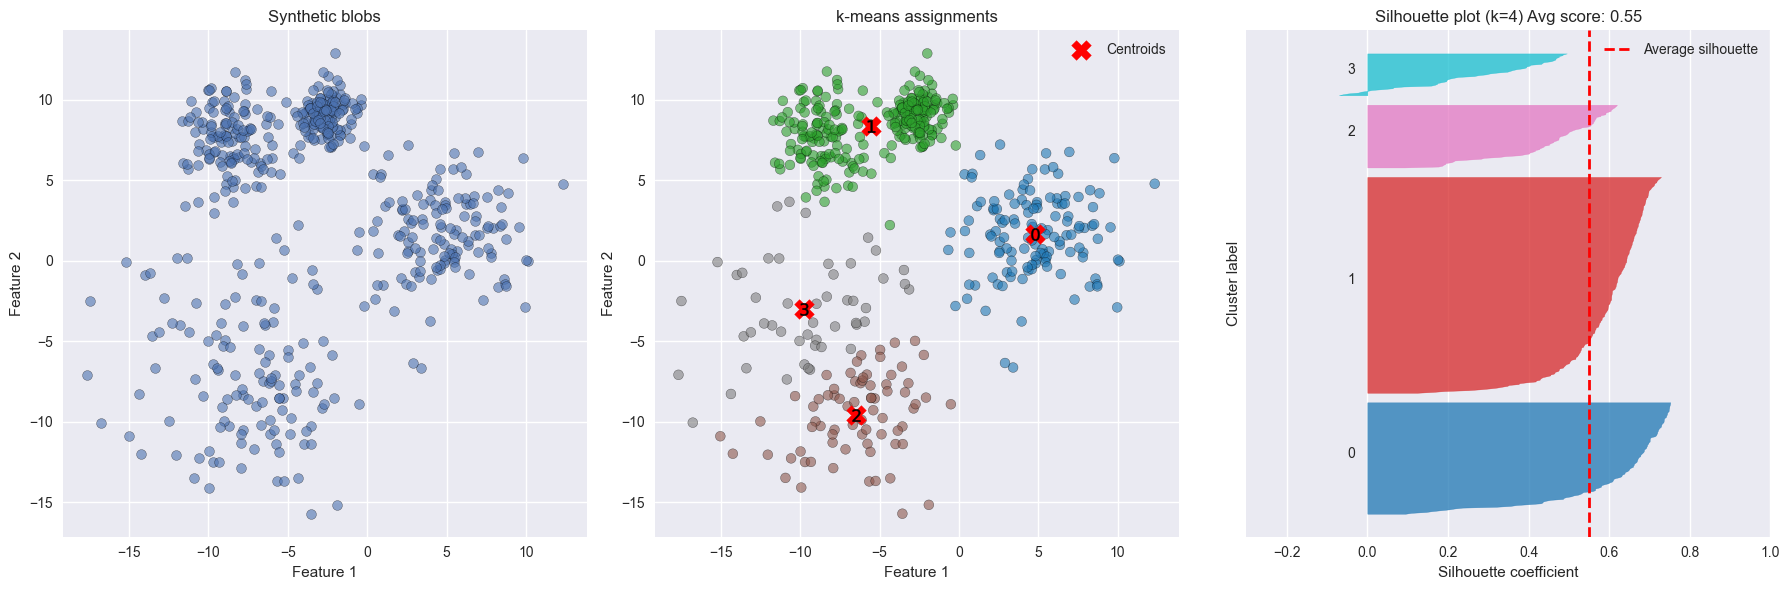

In [5]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
y_kmeans = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# (1) Original data
axes[0].scatter(X[:, 0], X[:, 1], s=50, alpha=0.6, edgecolor='k')
axes[0].set_title('Synthetic blobs')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# (2) Data coloured by predicted cluster
colours = cm.tab10(y_kmeans.astype(float) / n_clusters)
axes[1].scatter(X[:, 0], X[:, 1], c=colours, s=50, alpha=0.6, edgecolor='k')
axes[1].scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Centroids')
for idx, (cx, cy) in enumerate(centers):
    axes[1].scatter(cx, cy, marker=f'$%d$' % idx, c='black', s=80)
axes[1].set_title('k-means assignments')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].legend()

# (3) Silhouette analysis
evaluate_clustering(X, y_kmeans, n_clusters, ax=axes[2], title_suffix=' (k=4)')

plt.tight_layout()
plt.show()

> **Reflection:** Silhouette values close to 1 mean a point is well matched to its own cluster. Values near 0 lie on decision boundaries, and negative values suggest a point might fit better elsewhere.

## 5. How sensitive is k-means to its initialisation?
K-means starts from random centroid positions (unless you fix the seed). To appreciate the variability, let's run the algorithm several times and compare the results.

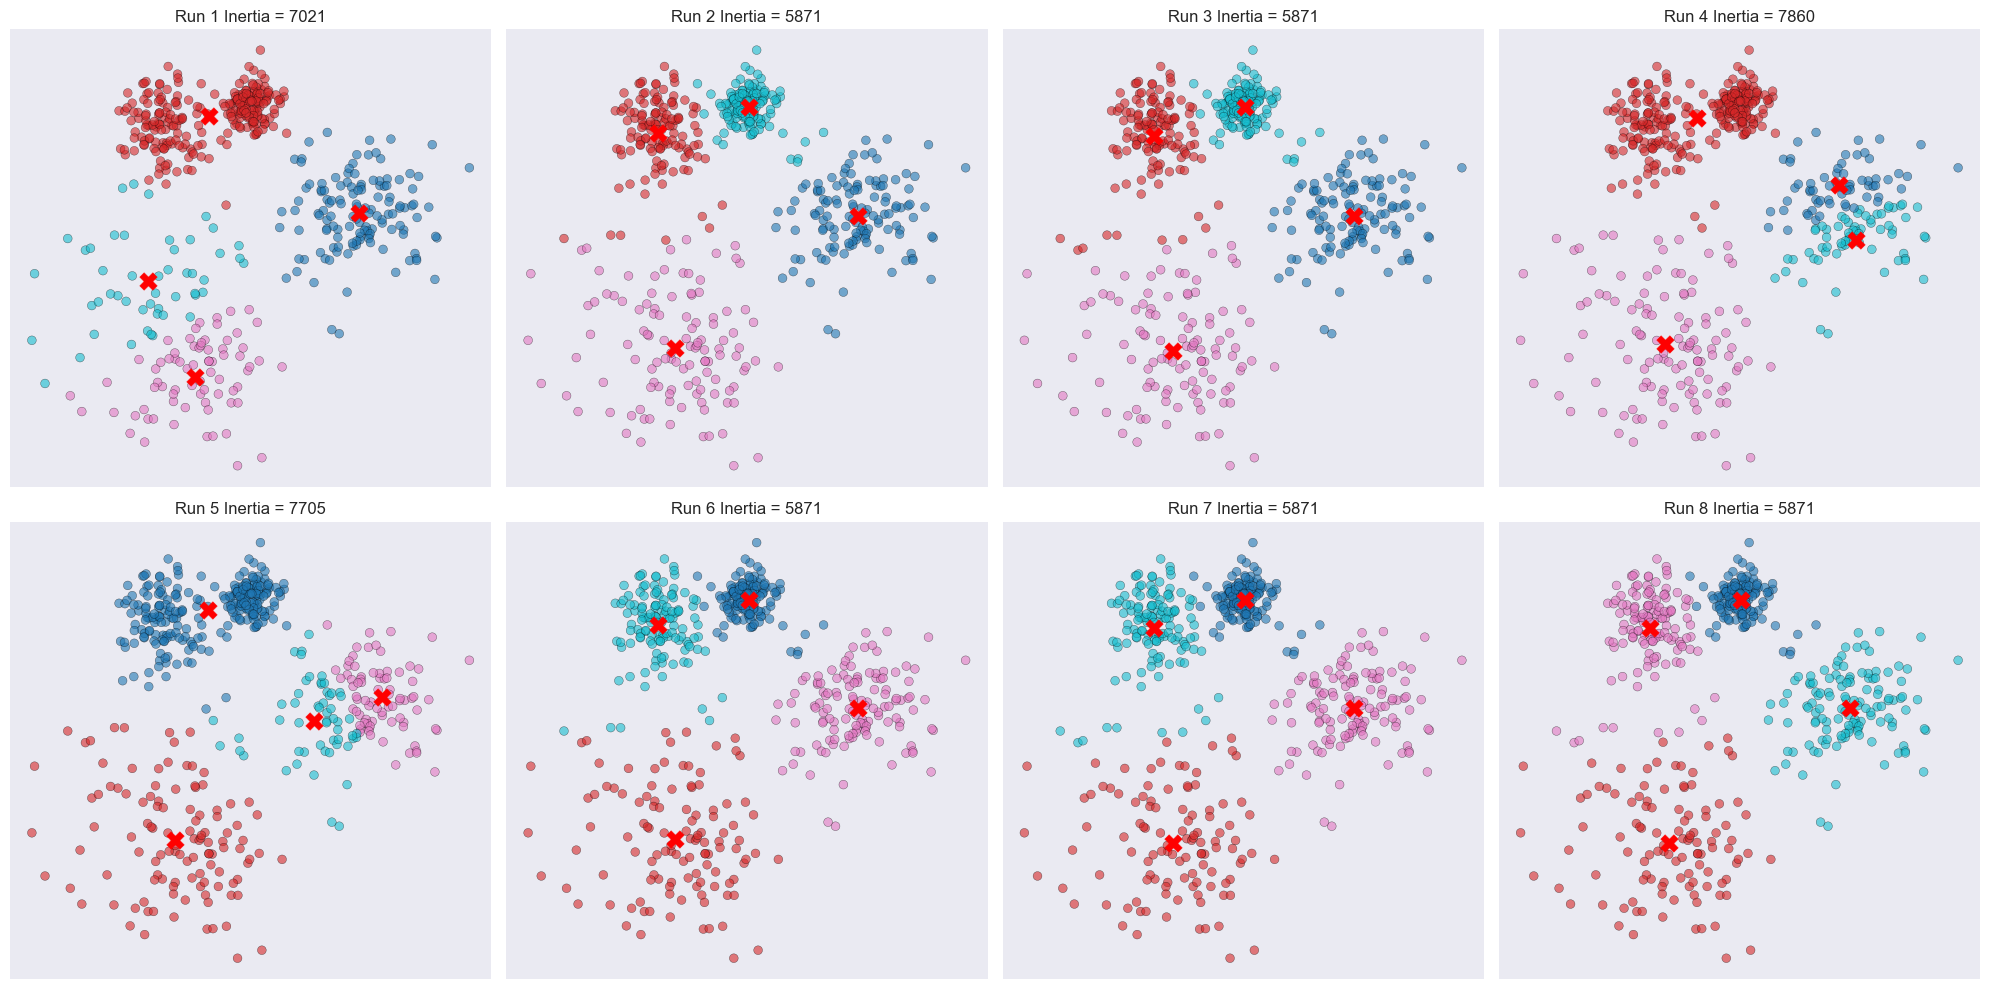

Run 1: inertia = 7020.84
Run 2: inertia = 5871.09
Run 3: inertia = 5871.49
Run 4: inertia = 7859.72
Run 5: inertia = 7705.43
Run 6: inertia = 5871.38
Run 7: inertia = 5871.49
Run 8: inertia = 5871.49


In [7]:
n_runs = 8
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()
inertia_values = []

for idx in range(n_runs):
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=None)
    labels = kmeans.fit_predict(X)
    inertia_values.append(kmeans.inertia_)

    axes[idx].scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', s=40, alpha=0.6, edgecolor='k')
    axes[idx].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=160, marker='X')
    axes[idx].set_title(f'Run {idx + 1} Inertia = {kmeans.inertia_:.0f}')
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

# Any remaining subplot (if n_runs is not a multiple of the grid size)
for ax in axes[n_runs:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

for run, inertia in enumerate(inertia_values, start=1):
    print(f'Run {run}: inertia = {inertia:.2f}')

> **Discuss:** Do the clusters—and the inertia scores—change much between runs? Stable results hint that our dataset is well behaved, but that is not always the case with real-world data.

## 6. Choosing the number of clusters
Classic heuristics include the elbow method (inertia), silhouette scores, and the Davies–Bouldin index. Let's compute them for $k$ between 2 and 10.

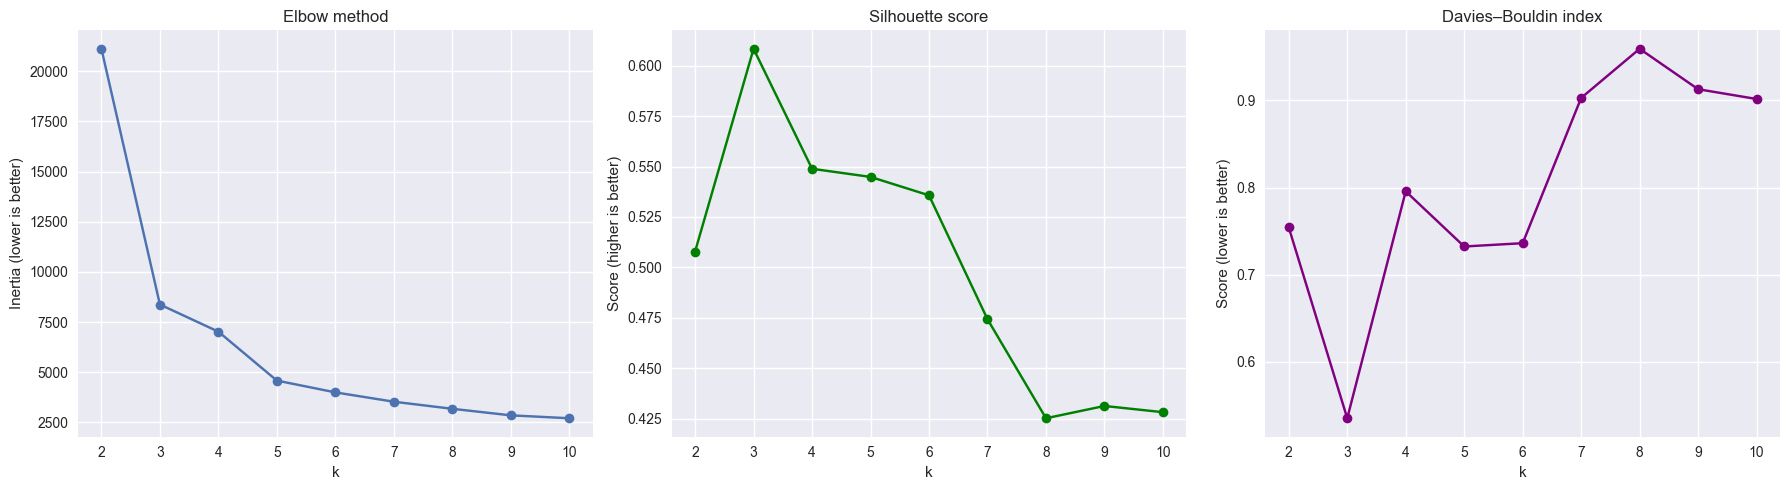

In [8]:
k_values = range(2, 11)
inertia_scores = []
silhouette_scores = []
db_indices = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = kmeans.fit_predict(X)

    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, labels))
    db_indices.append(davies_bouldin_score(X, labels))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(k_values, inertia_scores, marker='o')
axes[0].set_title('Elbow method')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inertia (lower is better)')

axes[1].plot(k_values, silhouette_scores, marker='o', color='green')
axes[1].set_title('Silhouette score')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Score (higher is better)')

axes[2].plot(k_values, db_indices, marker='o', color='purple')
axes[2].set_title('Davies–Bouldin index')
axes[2].set_xlabel('k')
axes[2].set_ylabel('Score (lower is better)')

plt.tight_layout()
plt.show()

> **Takeaway:** We know the ground truth is four clusters, yet the metrics often favour three. This tension is a reminder that evaluation is part science, part judgment.

## 7. Visual comparison for different values of k
To better understand what the metrics are telling us, let's directly inspect the cluster assignments and silhouettes for three candidate values of $k$.

/var/folders/7z/3g0v1_6s7dsgwp6470c3xkxm0000gn/T/ipykernel_79401/3274483214.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab10', max(candidate_k))
/var/folders/7z/3g0v1_6s7dsgwp6470c3xkxm0000gn/T/ipykernel_79401/755172194.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab10', len(unique_labels))
/var/folders/7z/3g0v1_6s7dsgwp6470c3xkxm0000gn/T/ipykernel_79401/755172194.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_

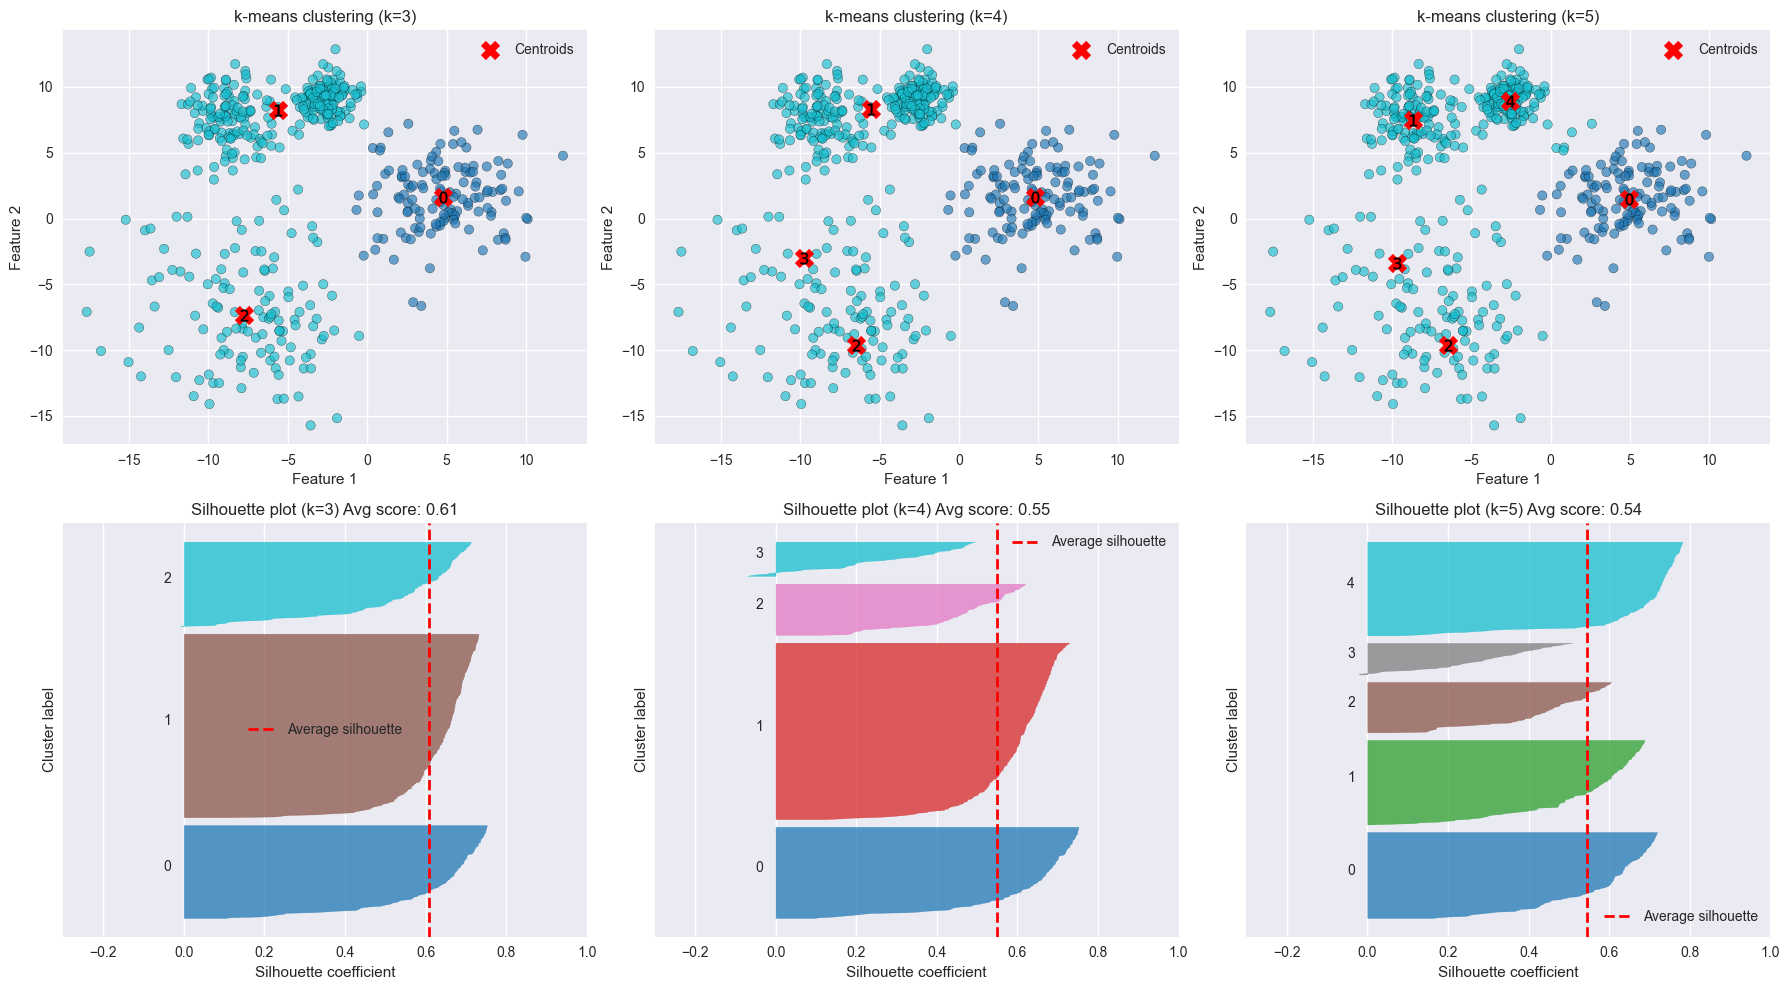

In [9]:
candidate_k = [3, 4, 5]
fig, axes = plt.subplots(2, len(candidate_k), figsize=(18, 10))
colormap = cm.get_cmap('tab10', max(candidate_k))

for col, k in enumerate(candidate_k):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = kmeans.fit_predict(X)
    centres = kmeans.cluster_centers_
    colour_values = colormap(labels.astype(float))
    axes[0, col].scatter(X[:, 0], X[:, 1], c=colour_values, s=45, alpha=0.65, edgecolor='k')
    axes[0, col].scatter(centres[:, 0], centres[:, 1], c='red', marker='X', s=180, label='Centroids')

    for label, (cx, cy) in enumerate(centres):
        axes[0, col].scatter(cx, cy, marker=f'$%d$' % label, c='black', s=70)

    axes[0, col].set_title(f'k-means clustering (k={k})')
    axes[0, col].set_xlabel('Feature 1')
    axes[0, col].set_ylabel('Feature 2')
    axes[0, col].legend(loc='upper right')

    evaluate_clustering(X, labels, k, ax=axes[1, col], title_suffix=f' (k={k})')

    axes[1, col].set_xlabel('Silhouette coefficient')

plt.tight_layout()
plt.show()

>For this dataset I'd choose **k = 4**. The scatter plots show four visually distinct density regions, and when k-means is allowed to create four clusters it cleanly separates the two denser blobs that were merged when k = 3. The silhouette plot for k = 4 still shows healthy positive scores for every cluster (despite a few boundary points), whereas the k = 3 silhouette has one block that dips closer to zero, signalling that some points are being stretched between two shapes. With k = 5 the additional cluster barely captures new structure—the silhouettes shrink and one block thins out, indicating over-segmentation. Overall, the silhouettes line up with what we see visually: k = 4 strikes the best balance between compact, well-separated clusters and respecting the underlying geometry.

## 8. When k-means struggles: non-spherical clusters
K-means implicitly prefers spherical, equally sized clusters. We'll now build a dataset with three classes whose shapes are not nicely spherical and see what happens.

/var/folders/7z/3g0v1_6s7dsgwp6470c3xkxm0000gn/T/ipykernel_79401/1942896748.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colourmap = cm.get_cmap('tab10', 3)
/var/folders/7z/3g0v1_6s7dsgwp6470c3xkxm0000gn/T/ipykernel_79401/755172194.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab10', len(unique_labels))
/var/folders/7z/3g0v1_6s7dsgwp6470c3xkxm0000gn/T/ipykernel_79401/755172194.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` inst

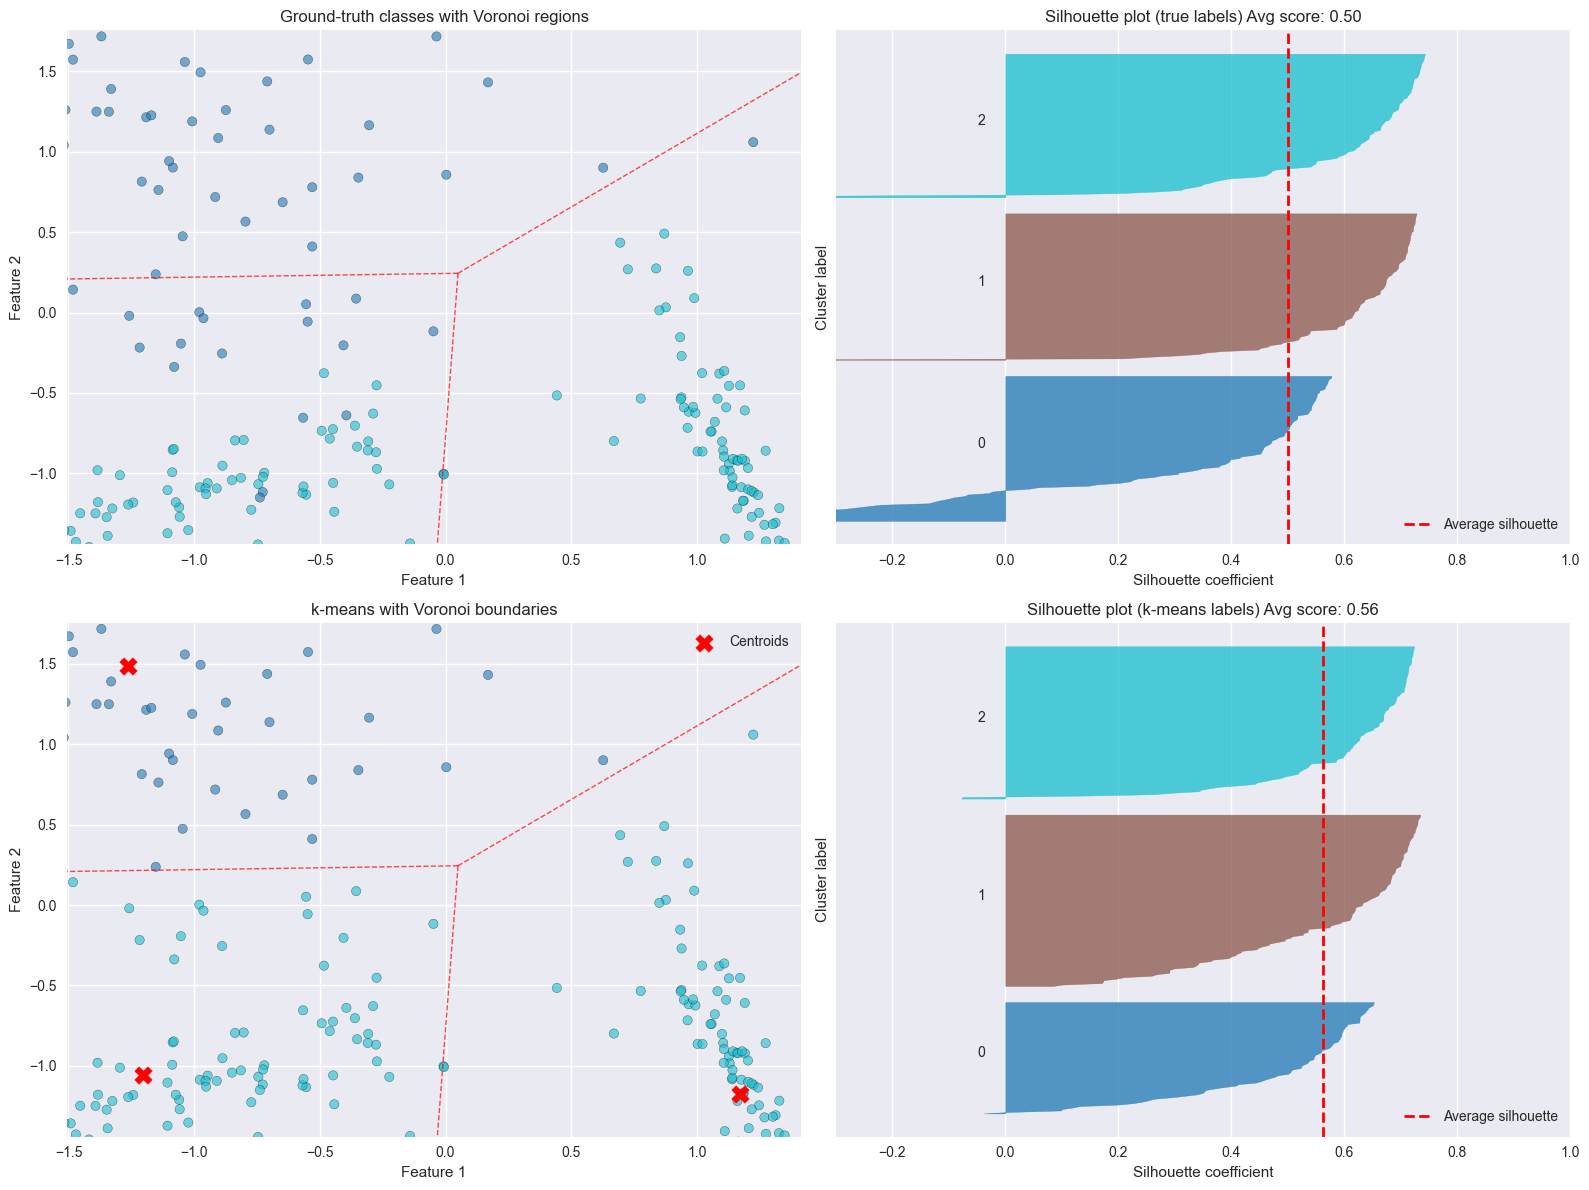

In [10]:
X_complex, y_complex = make_classification(
    n_samples=300,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    n_classes=3,
    flip_y=0.02,
    class_sep=1.2,
    random_state=7
)

kmeans_complex = KMeans(n_clusters=3, n_init='auto', random_state=7)
labels_complex = kmeans_complex.fit_predict(X_complex)
centroids = kmeans_complex.cluster_centers_
vor = Voronoi(centroids)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

colourmap = cm.get_cmap('tab10', 3)
true_colours = colourmap(y_complex.astype(float))
pred_colours = colourmap(labels_complex.astype(float))

# True labels
axes[0].scatter(X_complex[:, 0], X_complex[:, 1], c=true_colours, s=45, alpha=0.6, edgecolor='k')
voronoi_plot_2d(vor, ax=axes[0], show_vertices=False, line_colors='red', line_alpha=0.7, point_size=0)
axes[0].set_title('Ground-truth classes with Voronoi regions')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# Silhouette for ground-truth
evaluate_clustering(X_complex, y_complex, 3, ax=axes[1], title_suffix=' (true labels)')

# k-means assignments
axes[2].scatter(X_complex[:, 0], X_complex[:, 1], c=pred_colours, s=45, alpha=0.6, edgecolor='k')
axes[2].scatter(centroids[:, 0], centroids[:, 1], c='red', s=160, marker='X', label='Centroids')
voronoi_plot_2d(vor, ax=axes[2], show_vertices=False, line_colors='red', line_alpha=0.7, point_size=0)
axes[2].set_title('k-means with Voronoi boundaries')
axes[2].set_xlabel('Feature 1')
axes[2].set_ylabel('Feature 2')
axes[2].legend()

# Silhouette for k-means labels
evaluate_clustering(X_complex, labels_complex, 3, ax=axes[3], title_suffix=' (k-means labels)')
axes[3].set_xlabel('Silhouette coefficient')

plt.tight_layout()
plt.show()

> **Think about it:** Notice how k-means struggles to keep elongated structures intact. Density-based clustering (DBSCAN) or spectral clustering can work better in such cases.

## 9. Key lessons
- Always pair visual inspection with numeric scores. Both have blind spots.
- Run k-means multiple times or increase `n_init` when clusters seem unstable.
- Silhouette scores are intuitive but can favour fewer clusters when groups overlap.
- Be cautious with non-spherical or imbalanced data. Consider alternative clustering algorithms.

---
Happy practicing! Try tweaking parameters (standard deviations, separation, number of clusters) and rerun the notebook to deepen your intuition.